### Notebook to genereate time series from TC output

Will also mask out beyond TC area

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
September 2022

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# from matplotlib import ticker, cm
# import cartopy
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
# import matplotlib.colors as colors
import sys
import subprocess
# import cartopy
from azim_wind_latlon import azim_wind_latlon
from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
from mask_tc_track import mask_tc_track

#### Settings

In [90]:
# Main variable
iplot = 'vmf'
# options: vmf, thv, the, qrad

# Pressure bounds for integrated VMF
p0=1000
p1=500

# Calculate anomaly as deviation from xy-mean
do_prm_xy = 0

# Should be off for VMF
if iplot == 'vmf':
  do_prm_xy=0

# Strat/Conv index subset
istrat=2 # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
if istrat == -1:
  fig_extra=''
elif istrat == 0:
  fig_extra='_nonrain'
elif istrat == 1:
  fig_extra='_conv'
elif istrat == 2:
  fig_extra='_strat'
#fig_extra=''

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 8 # radius (deg) limit to keep unmasked

# #### Test/storm selection
storm = 'haiyan'
# storm = 'maria'

# Tests to read and compare
names = ['memb_01/ctl','memb_01/ncrf']#,'memb_02/ncrf','memb_03/ncrf','memb_04/ncrf','memb_05/ncrf','memb_05/crfon']
ntest = len(names)

# Tests to read and compare
# tests = ['ctl','ncrf']#'crfon'

# Starting member to read
# memb=['memb_01','memb_02','memb_03','memb_04','memb_05']

# Directories
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

#### Get dimensions

In [31]:
process = subprocess.Popen(['ls '+main+storm+'/memb_01/ctl/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
lat1d = lat[:,0]
lon1d = lon[0,:]
nx1 = lat1d.size
nx2 = lon1d.size
varfil_main.close()

varfil_main = Dataset(datdir+'T.nc')
nz = varfil_main.dimensions['level'].size
pres = varfil_main.variables['pres'][:] # hPa
dp = (pres[0]-pres[1])*1e2 # Pa
varfil_main.close()

ik0 = np.where(pres == p0)[0][0]
ik1 = np.where(pres == p1)[0][0]

#### Read data

In [131]:
# Time selection
nd = 4 # ndays
ntall = nd*24
hr_tag = str(np.char.zfill(str(nt), 2))

t0=0
t1 = t0+ntall

var_all = np.ma.masked_all((ntest,ntall))
# var_all[:]=np.nan

for n_itest in range(ntest):

    itest=names[n_itest]
    # print('Running memb: ',imemb)
    print('Running test: ',itest)

  # for itest in tests:

    # if imemb != 'memb_01' and itest == 'ctl': continue

    # if itest == 'ctl':
    #   test_t0=0
    # elif itest == 'ncrf':
    #   test_t0=36-1
    # elif itest == 'crfon':
    #   test_t0=84-1
    if 'ctl' in itest:
      test_t0=0
    elif 'ncrf' in itest:
      test_t0=36-1
    elif 'crfon' in itest:
      test_t0=84-1

    t1_read = t1-test_t0

    datdir = main+storm+'/'+itest+'/'+datdir2

    # Stratiform index
    if istrat != -1:
      strat = var_4d_read('strat',datdir,t0,t1_read) # 0-non-raining, 1-conv, 2-strat, 3-other/anvil

    # # Tangential winds
    # u = var_4d_read('U10',datdir,t0,t1_read) # m/s
    # v = var_4d_read('V10',datdir,t0,t1_read) # m/s
    # track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
    # vtan = azim_wind_latlon(track_file, u, v, lon, lat, t0, t1_read)
    # # SLP
    # slp = var_4d_read('SLP',datdir,t0,t1_read) # hPa

    # if iplot == 'thv' or iplot == 'the' or iplot == 'vmf' or iplot == 'rh' or iplot == 'rh':
    # Mixing ratio
    # qv = var_4d_read_pres('QVAPOR',datdir,t0,t1_read,ik0,ik1) # kg/kg
    # Temp
    # tmpk = var_4d_read_pres('QVAPOR',datdir,t0,t1_read,ik0,ik1) # K
    # Virtual potential temp
    # thv = theta_virtual(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K

    # Vertical mass flux
    # Vertical motion
    w = var_4d_read_pres('W',datdir,t0,t1_read,ik0,ik1) # m/s

    # Density
    # vmf *= density_moist(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # kg/m3
    vmf = np.sum(w,axis=1) * dp * 1./9.81 # kg/m/s
    vmf = vmf[:,np.newaxis,:,:]

    # Standard masking OR mask for istrat only
    vmf = np.ma.masked_where((strat != istrat), vmf, copy=True)
    vmf_tser = mask_and_avg(vmf, rmax)

    var_all[n_itest,test_t0:t1]=vmf_tser[:,0]
    # if test_t0 > t0: var_all[n_itest,t0:test_t0-1]=np.nan

Running test:  memb_01/ctl
Running test:  memb_01/ncrf


In [16]:
# Function to read 4d variable
def var_4d_read(vartag,datdir,t0,t1):
    varfil = Dataset(datdir+vartag+'.nc')
    var = varfil.variables[vartag][t0:t1,:,:,:]
    varfil.close()
    return var

In [24]:
# Function to read 4d variable over specific pressure bounds
def var_4d_read_pres(vartag,datdir,t0,t1,ik0,ik1):
    varfil = Dataset(datdir+vartag+'.nc')
    var = varfil.variables[vartag][t0:t1,ik0:ik1,:,:]
    varfil.close()
    return var

In [104]:
# Function to mask out and average
def mask_and_avg(var, rmax):
    # Localize to TC track
    track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
    var_mask = mask_tc_track(track_file, rmax, var, lon, lat, t0, t1_read)
    # Average in x,y
    var_tser = np.mean(var_mask,axis=(2,3))
    return var_tser

---
### Plotting routines

In [108]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

#### VTAN time series

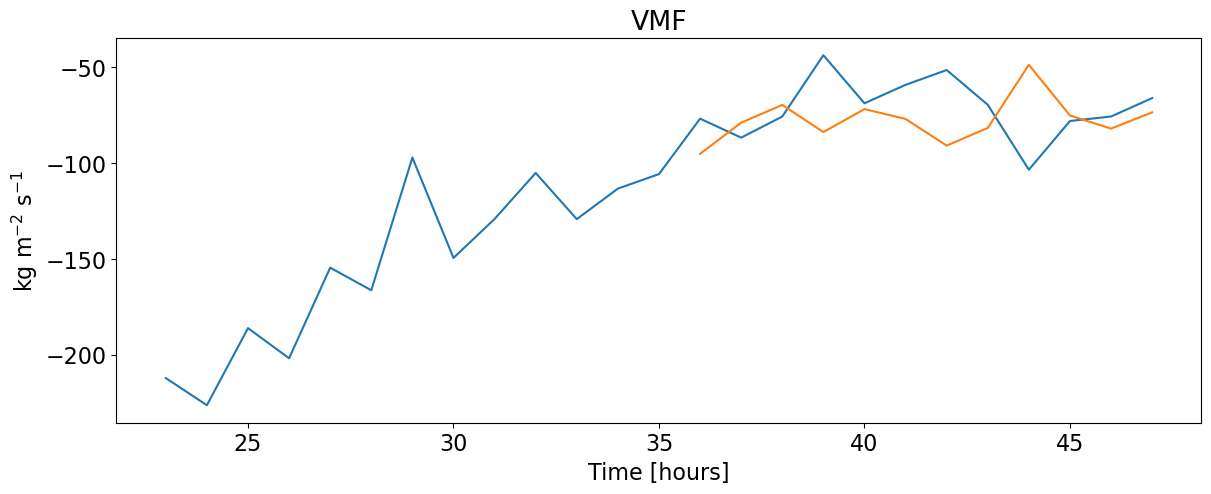

In [135]:
# Figure settings
fig_title='VMF'
fig_tag='vmf'
units_var='kg m$^{-2}$ s$^{-1}$'

# create figure
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(111)

ax.set_title(fig_title)
ax.set_ylabel(units_var)
ax.set_xlabel('Time [hours]')

for iplt in range(ntest):
    plt.plot(range(t0,t1), var_all[iplt,:])
# plt.plot(range(t0,t1), var_all[0,:], "-k")
# plt.plot(range(t0,t1), var_all[1,:], "-r")

# ax2=ax.twinx()
# ax2.set_ylabel('SLP [hPa]')
# ax2.plot(range(t0,t1), slp_min) #, "-k")

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)